In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import random

In [2]:
dataset_dir = 'Aerial_Landscapes'
categories = ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland',
              'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']

In [3]:
lbp_radius = 1
lbp_n_points = 8 * lbp_radius
lbp_method = 'uniform'
resize_size = (128, 128)

In [4]:
# Set the number in descending order based on the training set (with an upper limit of 640 images per class, i.e., 80% of 800).
category_limits = {cat: int(640 - i * 40) for i, cat in enumerate(categories)}

In [5]:
def extract_lbp_features(img_gray):
    lbp = local_binary_pattern(img_gray, lbp_n_points, lbp_radius, lbp_method)
    hist, _ = np.histogram(lbp.ravel(),
                           bins=np.arange(0, lbp_n_points + 3),
                           range=(0, lbp_n_points + 2))
    hist = hist.astype("float")
    hist /= hist.sum()
    return hist

In [6]:
train_paths = []
train_labels = []
test_paths = []
test_labels = []

In [7]:
for category in categories:
    folder_path = os.path.join(dataset_dir, category)
    img_list = os.listdir(folder_path)
    random.shuffle(img_list)

    total_imgs = len(img_list)
    split_idx = int(total_imgs * 0.8)  # 80% train, 20% test
    train_list = img_list[:split_idx]
    test_list = img_list[split_idx:]

    # The imbalanced number of samples in the training set
    limit = category_limits[category]
    selected_train_list = train_list[:limit]

    for img_name in selected_train_list:
        train_paths.append(os.path.join(folder_path, img_name))
        train_labels.append(category)

    for img_name in test_list:
        test_paths.append(os.path.join(folder_path, img_name))
        test_labels.append(category)

In [8]:
X_train = []
for path in train_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None: continue
    img = cv2.resize(img, resize_size)
    feat = extract_lbp_features(img)
    X_train.append(feat)

In [9]:
X_test = []
for path in test_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None: continue
    img = cv2.resize(img, resize_size)
    feat = extract_lbp_features(img)
    X_test.append(feat)

In [10]:
le = LabelEncoder()
y_train = le.fit_transform(train_labels)
y_test = le.transform(test_labels)
X_train = np.array(X_train)
X_test = np.array(X_test)

In [11]:
clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
clf.fit(X_train, y_train)

SVC(C=10, probability=True)

In [12]:
dump(clf, 'lbp_svm_model_imbalanced.joblib')
dump(le, 'label_encoder_imbalanced.joblib')
print("Model saved as lbp_svm_model_imbalanced.joblib")

Model saved as lbp_svm_model_imbalanced.joblib


In [13]:
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

Accuracy: 0.4813
Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.38      0.59      0.46       160
     Airport       0.23      0.52      0.32       160
       Beach       0.33      0.56      0.42       160
        City       0.39      0.71      0.50       160
      Desert       0.54      0.43      0.48       160
      Forest       0.77      0.88      0.82       160
   Grassland       0.77      0.76      0.76       160
     Highway       0.46      0.47      0.47       160
        Lake       0.56      0.52      0.54       160
    Mountain       0.45      0.53      0.49       160
     Parking       0.77      0.56      0.65       160
        Port       0.79      0.34      0.47       160
     Railway       0.65      0.12      0.21       160
 Residential       0.71      0.22      0.33       160
       River       0.00      0.00      0.00       160

    accuracy                           0.48      2400
   macro avg       0.52      0.48      0

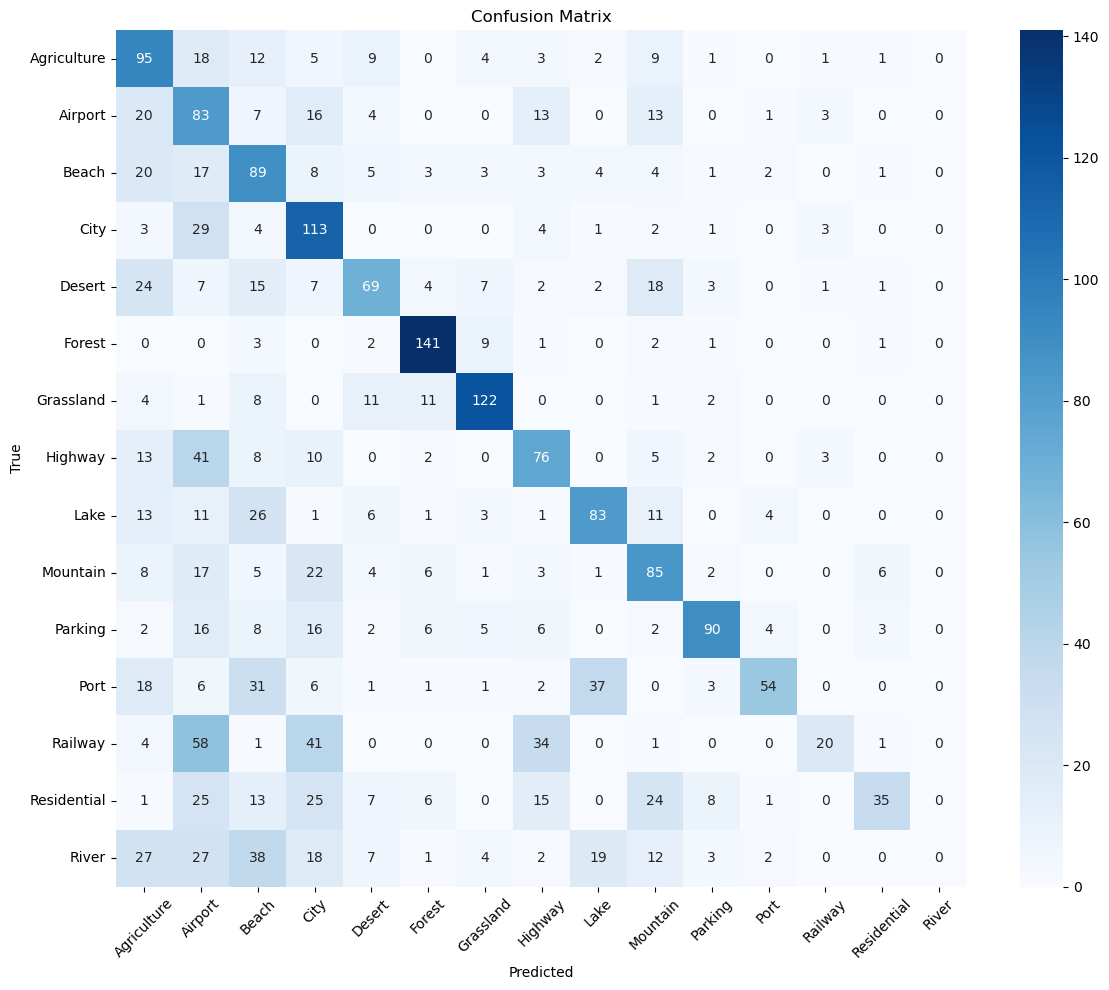

In [14]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("confusion_matrix_imbalanced.png")
plt.show()

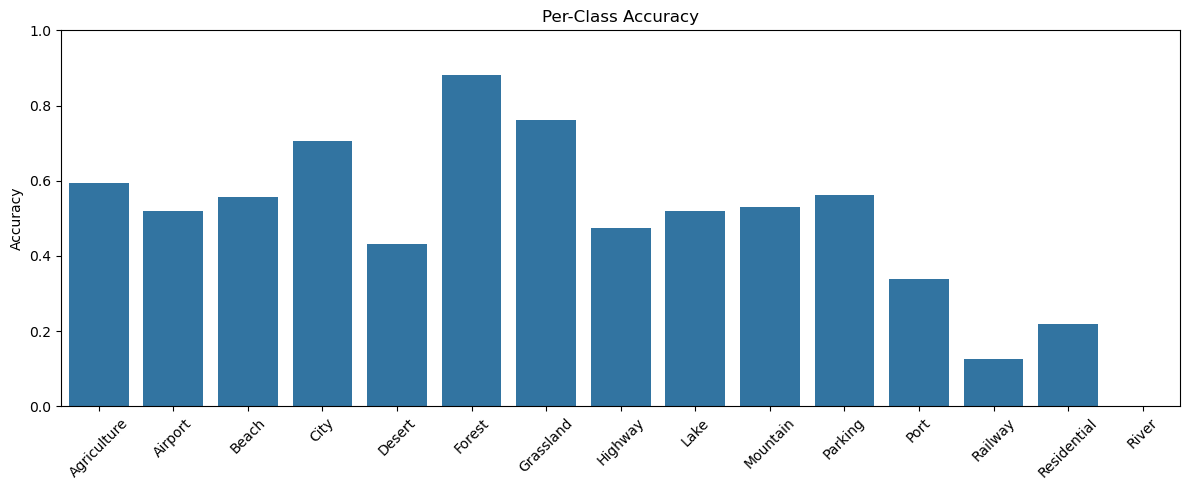

In [15]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12, 5))
sns.barplot(x=le.classes_, y=class_accuracy)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig("per_class_accuracy_imbalanced.png")
plt.show()